# Code Review and Project Workflow Analysis for Git Data

1. Commit Message Interpretation: LLMs will interpret commit messages, correlating them with corresponding diffs to generate meaningful summaries that highlight the purpose and intent behind each change. This includes identifying the nature of the commit (e.g., bug fix, feature addition, refactor).
2. Diff Summarization: LLMs will analyze code diffs to provide summaries of the specific modifications made, such as the introduction of new classes, changes to algorithms, or updates to dependencies, helping reviewers quickly understand the scope of changes.
3. Categorization of Commits: LLMs will categorize commits based on patterns detected in their content, grouping them into categories such as "feature development," "bug fixes," "performance improvements," or "refactoring efforts," making it easier to track the project's evolution by type of change.


## Importing Libraries

In [ ]:
from git import Repo
import os
import re
import subprocess
import torch
import datetime
import pickle
import copy
import numpy as np
import random
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, set_seed
from collections import defaultdict
from tqdm import tqdm
from huggingface_hub import login
import matplotlib.pyplot as plt

set_seed(42) # Ensure reproducibility
TOKEN = ""

(token=TOKEN)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
current_directory = os.getcwd()

## Git Fetching and Preprocessing functions

#### 1. **`extract_git_commits(repo_path, branch='master')`**
- **Purpose**: Extracts detailed commit information from a Git repository, including commit hashes, author details, dates, messages, modified files, and diffs.
- **Input**: Path to the Git repository (`repo_path`) and the branch name (`branch`).
- **Output**: A dictionary of commits with indexed details.

#### 2. **`filter_trivial_commits(commits_dict, trivial_patterns=None, min_diff_lines=5)`**
- **Purpose**: Filters out trivial commits based on commit message patterns (e.g., "merge branch") and the number of lines changed in the diffs.
- **Input**:
  - `commits_dict`: Dictionary of extracted commits.
  - `trivial_patterns`: List of regex patterns for trivial commits (default provided).
  - `min_diff_lines`: Minimum number of lines in a diff to retain the commit (default is 5).
- **Output**: A filtered dictionary of commits excluding trivial ones.

#### 3. **`normalize_commit_data(commit_data)`**
- **Purpose**: Normalizes commit messages to ensure consistent capitalization, removes redundant phrases, excessive punctuation, and standardizes terminology.
- **Input**: Dictionary of commits with raw messages.
- **Output**: Dictionary with normalized commit messages.



In [ ]:
def filter_diff_lines(diff_text):
    """
    Filtra le righe di un diff Git, mantenendo solo quelle che iniziano con '+' o '-',
    escludendo le intestazioni dei file ('+++', '---').

    Args:
        diff_text (str): Il testo del diff Git.

    Returns:
        str: Le righe filtrate del diff.
    """
    filtered_lines = []
    for line in diff_text.splitlines():
        # Include lines that start with '+' or '-' but exclude '+++' or '---'
        if (line.startswith('+') or line.startswith('-')) and not line.startswith('+++') and not line.startswith('---'):
            filtered_lines.append(line)
    return '\n'.join(filtered_lines)

def extract_git_commits(repo_path, branch='master'):
    """
    Extracts commit information from a Git repository.
    """
    repo = Repo(repo_path)
    commits = list(repo.iter_commits(branch))
    commits_dict = {}

    for i, commit in enumerate(commits):
        commits_dict[i] = {
            'hash': commit.hexsha,
            'author': f"{commit.author.name} <{commit.author.email}>",
            'date': commit.authored_datetime,
            'message': commit.message.strip(),
            'files': list(commit.stats.files.keys()),
            'diffs': {},
            'llama_summary': '',
            'llama_category': '',
            'llama_tech_summary': ''
        }

        diffs = commit.diff(commit.parents[0] if commit.parents else None, create_patch=True)

        for diff in diffs:
            file_diff = diff.diff.decode('utf-8')
            file_name = f"{diff.a_path} -> {diff.b_path}" if diff.a_path != diff.b_path else diff.a_path
            commits_dict[i]['diffs'][file_name] = filter_diff_lines(file_diff)

    print(f"Extracted {len(commits_dict)} commits")
    return commits_dict


def filter_trivial_commits(commits_dict, trivial_patterns=None, min_diff_lines=5):
    """
    Filters out trivial commits based on patterns and diff size.
    To add a new trivial pattern, add it to the trivial_patterns list below.
    """

    if trivial_patterns is None:
        trivial_patterns = [
            r"merge branch",        # Merging branches
            r"fix typo",            # Fixing typos
            r"readme",              # Updating documentation
            r"minor",               # General minor changes
            r"release"              # Release versions
            r"cleanup"              # Cleanups
        ]

    filtered_commits = {}
    filtered_number = 0

    for index, commit in commits_dict.items():
        # Check commit message for trivial patterns
        if any(re.search(pattern, commit['message'], re.IGNORECASE) for pattern in trivial_patterns):
            filtered_number += 1
            continue

        # Check diff size (number of lines changed)
        total_diff_lines = sum(len(diff.splitlines()) for diff in commit['diffs'].values())
        if total_diff_lines < min_diff_lines:
            filtered_number += 1
            continue

        # If commit passes all filters, include it
        filtered_commits[index] = commit

    print(f"Filtered {filtered_number} commits")
    return filtered_commits


def normalize_commit_data(commit_data):
    """
    Normalize all commit messages in a dictionary of git data.
    """

    def normalize_message(message):
        """
        Normalize a single git commit message.
        """
        # Remove leading/trailing whitespace and ensure capitalization
        normalized = message.strip().capitalize()

        # Replace multiple spaces or tabs with a single space
        normalized = re.sub(
          r'\s+', ' ', normalized)

        # Remove repetitive or excessive comments like "!!!!!" or "..."
        normalized = re.sub(r'[!?.]{2,}', '.', normalized)

        # Eliminate redundant phrases or filler words
        redundant_phrases = [
            r"\bthis commit\b", r"\bminor fix\b", r"\bsmall update\b",
            r"\bquick fix\b", r"\btemporary change\b", r"\btest commit\b"
        ]
        for phrase in redundant_phrases:
            normalized = re.sub(phrase, '', normalized, flags=re.IGNORECASE).strip()

        # Simplify common patterns
        normalized = re.sub(r'\bAdded\b', 'Add', normalized, flags=re.IGNORECASE)
        normalized = re.sub(r'\bRemoved\b', 'Remove', normalized, flags=re.IGNORECASE)
        normalized = re.sub(r'\bFixed\b', 'Fix', normalized, flags=re.IGNORECASE)

        # Standardize specific keywords
        normalized = re.sub(r'\bBugfix\b', 'Bug fix', normalized, flags=re.IGNORECASE)
        normalized = re.sub(r'\bRefactored\b', 'Refactor', normalized, flags=re.IGNORECASE)

        # Ensure the message ends with a period if it doesn't already
        if not normalized.endswith('.'):
            normalized += '.'

        return normalized

    # Iterate through each commit and normalize the message
    for index, commit in commit_data.items():
        if "message" in commit:
            commit["message"] = normalize_message(commit["message"])

    print("Normalize commits done")
    return commit_data

def clean_text_paragraph(text):
    """
    Cleans a text paragraph by removing unnecessary blank lines
    and excessive indentation.
    """
    lines = text.splitlines()
    cleaned_lines = [line.strip() for line in lines if line.strip()]
    cleaned_text = "\n".join(cleaned_lines)

    return cleaned_text

## LLM-based Summarization functions

### 1. **`generate_prompt_summarization(commit)`**
- **Purpose**: Creates a prompt to instruct a language model to summarize a git commit.
- **Input**:
  - `commit` (dict): A dictionary containing:
    - `hash`: Unique identifier of the commit.
    - `author`: Name of the commit author.
    - `date`: Commit date in datetime format.
    - `message`: Commit message.
    - `files`: List of modified files.
    - `diffs`: Dictionary of diffs per file.
- **Output**:
  - A string prompt formatted to include all relevant commit details (hash, author, date, message, modified files, and diffs). This prompt is designed to guide a model in generating a concise and meaningful summary of the commit.


### 2. **`generate_prompt_summarization_few_shots(commit, categories=CATEGORIES)`**
- Same as before, but with few shots prompt

### 3. **`ask_model_summarization(prompt, pipe)`**
- **Purpose**: Sends the generated prompt to a language model for summarization.
- **Input**:
  - `prompt` (str): A prompt generated by `generate_prompt_summarization`.
  - `pipe` (Hugging Face pipeline): A text generation pipeline, such as one created using `transformers.pipeline`.
- **Output**:
  - Returns a concise summary of the commit generated by the model.


In [ ]:
def generate_prompt_summarization(commit):
    """
    Generate a prompt for summarizing a git commit.
    """
    prompt = f"""
        You are a helpful assistant. Provide a concise description of what has been done in the following commit:

        Commit Infomations:
        - Hash (unique identifier): {commit['hash']}
        - Author: {commit['author']}
        - Date: {commit['date'].strftime('%Y-%m-%d %H:%M:%S')}

        Commit Message - this provides a brief summary of the changes:
        {commit['message']}

        Changed Files - files modified in this commit:
        {', '.join(commit['files'])}

        Diffs - lines of code changed in each file, use this to understand the specific changes:
        {chr(10).join([f"{file_name}: {diff[:1000]}" for file_name, diff in commit['diffs'].items()])}

        Use all the informations available to analyze the changes focusing on the purpose, key changes, and significance.
        Exclude unnecessary technical details and make it easy to understand for a project manager or developer.

        Do not repeat the prompt. Do no repeat any of the information provided above. Do not include lines of code

        Answer:
        """
    prompt = clean_text_paragraph(prompt)
    return prompt


def generate_prompt_summarization_few_shots(commit):
    prompt = f"""
        You are a helpful assistant. Provide a concise description of what has been done in the following commits.

        Example 1:
        Commit Informations:
        - Hash (unique identifier): 1a2b3c4d
        - Author: John Doe
        - Date: 2025-01-01 10:00:00
        Commit Message - this provides a brief summary of the changes:
        Refactored the user authentication module to improve performance and readability.
        Changed Files - files modified in this commit:
        auth.py, user_model.py
        Diffs - lines of code changed in each file:
        auth.py:
        ```diff
        - def authenticate_user(username, password):
        -     if username and password:
        -         return check_credentials(username, password)
        + def authenticate_user(user_credentials):
        +     return validate_user(user_credentials)
        ```
        user_model.py:
        ```diff
        + def validate_user(credentials):
        +     # New validation logic for login
        +     return is_valid(credentials)
        ```
        Answer:
        Refactored the user authentication system to improve both performance and readability.
        Key changes include replacing the `authenticate_user` function to accept a `user_credentials` object instead of separate username and password arguments, simplifying the interface and making the code less error-prone.
        Additionally, a new `validate_user` function was introduced in `user_model.py` to centralize login validation logic, improving modularity and enabling easier future updates.
        These changes make the authentication process more robust and align with modern software design principles.

        Example 2:
        Commit Informations:
        - Hash (unique identifier): 5e6f7g8h
        - Author: Jane Smith
        - Date: 2025-01-02 14:30:00
        Commit Message - this provides a brief summary of the changes:
        Added a new feature for exporting reports to CSV.
        Changed Files - files modified in this commit:
        report_exporter.py, utils/csv_writer.py
        Diffs - lines of code changed in each file:
        report_exporter.py:
        ```diff
        + def export_to_csv(data, filename):
        +     with open(filename, 'w') as file:
        +         writer = csv.writer(file)
        +         writer.writerow(data.keys())
        +         writer.writerows(data.values())
        ```
        utils/csv_writer.py:
        ```diff
        + import csv
        ```
        Answer:
        Added a new feature for exporting reports to CSV format, enabling users to easily extract structured data.
        Key changes include introducing the `export_to_csv` function in `report_exporter.py`, which uses Python’s built-in CSV library to create files with appropriate headers and rows based on the input data.
        The `utils/csv_writer.py` module was also updated to include CSV-related utilities, promoting code reuse and reducing duplication across the project.
        This enhancement significantly improves the usability of the reporting system, particularly for end users who need seamless integration with external tools like Excel.

        Example 3:
        Commit Informations:
        - Hash (unique identifier): b2c4d6e8
        - Author: Alice Brown
        - Date: 2024-03-15 16:42:10
        Commit Message - this provides a brief summary of the changes:
        Fixed scope handling for function declarations in JavaScript compilation.
        Changed Files - files modified in this commit:
        jscompiler.c
        Diffs - lines of code changed in each file:
        jscompiler.c:
        ```diff
        - static void compile_function_body(JF, js_Ast *name, js_Ast *params, js_Ast *body, int is_fun_exp);
        + static void compile_function_body(JF, js_Ast *name, js_Ast *params, js_Ast *body);
        - static js_Function *create_function(js_State *J, int line, js_Ast *name, js_Ast *params, js_Ast *body, int script, int strict, int is_fun_exp);
        + static js_Function *create_function(js_State *J, int line, js_Ast *name, js_Ast *params, js_Ast *body, int script, int strict);
        ```
        Answer:
        Addressed an issue with scope handling for function declarations in the JavaScript compiler.
        The key change involved removing the `is_fun_exp` parameter from the `compile_function_body` and `create_function` methods, simplifying the handling of function declaration bindings.
        This improves code clarity and correctness, ensuring that function declarations adhere to the expected scope rules.
        These updates pave the way for further improvements, such as making function expression bindings immutable, which aligns with the long-term goals for the compiler's behavior.


        Now analyze the following commit:

        Commit Informations:
        - Hash (unique identifier): {commit['hash']}
        - Author: {commit['author']}
        - Date: {commit['date'].strftime('%Y-%m-%d %H:%M:%S')}
        Commit Message - this provides a brief summary of the changes:
        {commit['message']}
        Changed Files - files modified in this commit:
        {', '.join(commit['files'])}
        Diffs - lines of code changed in each file:
        {chr(10).join([f"{file_name}: {diff[:1000]}" for file_name, diff in commit['diffs'].items()])}

        Use all the informations available to analyze the changes focusing on the purpose, key changes, and significance.
        Exclude unnecessary technical details and make it easy to understand for a project manager or developer.

        Do not repeat the prompt. Do no repeat any of the information provided above. Do not include lines of code
        Answer:
    """
    prompt = clean_text_paragraph(prompt)
    return prompt



def ask_model_summarization(prompt, pipe):
    """
    Ask the model to summarize a git commit.
    """
    answer = pipe(
        prompt,
        max_new_tokens=200,
        do_sample=False,
        temperature=None,
        top_p=None,
    )[0]['generated_text']

    answer = answer.split("Answer:")[-1]
    return answer



## LLM-based Categorization functions

### 1. **`generate_prompt_categorization(commit, categories=CATEGORIES)`**
- **Purpose**: Generates a prompt to instruct a language model to categorize a git commit into one of the predefined categories.
- **Parameters**:
  - `commit` (dict): A dictionary containing the following commit details:
    - `hash` (str): Unique identifier of the commit.
    - `author` (str): Name of the commit author.
    - `date` (datetime): Date of the commit.
    - `message` (str): Commit message summarizing the changes.
    - `files` (list): List of modified files.
    - `diffs` (dict): Dictionary of diffs for each file.
  - `categories` (list, optional): List of categories to choose from. Defaults to `CATEGORIES`.
  
- **Output**:
  - Returns a string prompt formatted to include all relevant commit details (hash, author, date, message, modified files, and diffs), designed to guide the language model in categorizing the commit.

### 2. **`generate_prompt_categorization_few_shots(commit, categories=CATEGORIES)`**
- Same as before, but with few shots prompt

### 3. **`ask_model_categorization(prompt, pipe)`**
- **Purpose**: Sends the generated prompt to a language model to categorize the git commit.
- **Parameters**:
  - `prompt` (str): The prompt generated by `generate_prompt_categorization`.
  - `pipe` (Hugging Face pipeline): A text generation pipeline (such as `transformers.pipeline`) for querying the language model.
  
- **Output**:
  - Returns the most appropriate category name for the commit based on the model's response.

In [ ]:
CATEGORIES = [
    "Feature Update",
    "Bug Fix",
    "Documentation Update",
    "Refactoring",
    "Performance Improvement",
    "Test Addition/Update",
    "Dependency Update",
    "Build/CI Change",
    "Style Update",
    "Other"
]


def generate_prompt_categorization_zero_shot(commit, categories=CATEGORIES):
    """
    Generate a zero-shot prompt for categorizing a Git commit.
    """

    categories_text = '\n'.join([f"{i + 1}. {category}" for i, category in enumerate(categories)])
    prompt = f"""
    You are tasked with categorizing commits based on their purpose and significance. Use the following categories:

    {categories_text}

    Each commit has the following details:
    - **Commit Informations:**
      - **Hash (unique identifier):** {commit['hash']}
      - **Author:** {commit['author']}
      - **Date:** {commit['date'].strftime('%Y-%m-%d %H:%M:%S')}
      - **Commit Message:** {commit['message']}
      - **Changed Files:** {', '.join(commit['files'])}
      - **Diffs:** The following are the lines of code changed in each file:
        {chr(10).join([f"{file_name}: {diff[:1000]}" for file_name, diff in commit['diffs'].items()])}

    **Instructions:**
    1. Review the commit information carefully, including the message, modified files, and code diffs.
    2. Classify the commit into one of the provided categories.
    3. Provide a single category from the list based on the purpose and significance of the changes.

    Provide the category based on the purpose and significance of the commit.
    Category:
    """
    prompt = clean_text_paragraph(prompt)
    return prompt

def generate_prompt_categorization_few_shots(commit, categories=CATEGORIES):
    """
    Generate a prompt for categorizing a Git commit.
    """

    categories_text = '\n'.join([f"{i + 1}. {category}" for i, category in enumerate(categories)])
    prompt = f"""
    You are tasked with categorizing commits based on their purpose and significance. Use the following categories:

      {categories_text}

      Each commit has the following details:
      - **Commit Informations:**
        - **Hash (unique identifier):**
        - **Author (person who did the commit)**
        - **Date(date in which the commit was done)**
        - **Commit Message (breif explanation of what’s been changed inside the commit)**
        - **Changed Files: (list of files affected from the commit)*
        - **Diffs (Lines of code changed in each file)**

      **Instructions:**
      1. Review the commit information carefully, including the message, modified files, and code diffs.
      2. Classify the commit into one of the provided categories.
      3. Provide a single category from the list based on the purpose and significance of the changes.

      **Example 1 :**

      Commit Informations:
      - Hash (unique identifier): 1a2b3c4d
      - Author: John Doe
      - Date: 2025-01-01 10:00:00
      - Commit Message: Refactored the user authentication module to improve performance and readability.
      - Changed Files: auth.py, user_model.py
      - Diffs:
        auth.py:
        ```diff
        - def authenticate_user(username, password):
        -     if username and password:
        -         return check_credentials(username, password)
        + def authenticate_user(user_credentials):
        +     return validate_user(user_credentials)
      user_model.py:
      + def validate_user(credentials):
      +     # New validation logic for login
      +     return is_valid(credentials)
      **category**: Refactoring

      **Example 2 :**
      Commit Informations:
      - Hash (unique identifier): 3c2b1a4f
      - Author: Alex Brown
      - Date: 2025-01-03 12:00:00
      - Commit Message: Updated the README with installation instructions and new feature descriptions.
      - Changed Files: README.md
      - Diffs:
      README.md:
      ```diff
      + ## Installation
      + Run the following command to install:
      + pip install mypackage
      **category**: Documentation Update

      **Example 3 : **
      Commit Informations:
      - Hash (unique identifier): 9f8e7d6c
      - Author: Jane Smith
      - Date: 2025-01-02 15:00:00
      - Commit Message: Fixed incorrect handling of null values in user profile updates.
      - Changed Files: profile.py
      - Diffs:
      profile.py:
      ```diff
      - if user['name']:
      + if user.get('name') is not None:
      **category**: Bug Fix


      Now, analyze the following commit:

      Commit Informations:

      Hash (unique identifier): {commit['hash']}
      Author: {commit['author']}
      Date: {commit['date'].strftime('%Y-%m-%d %H:%M:%S')}
      Commit Message: {commit['message']}
      Changed Files: {', '.join(commit['files'])}
      Diffs: {chr(10).join([f"{file_name}: {diff[:1000]}" for file_name, diff in commit['diffs'].items()])}
      Provide the category based on the purpose and significance of the commit.
      Category:

    """

    prompt = clean_text_paragraph(prompt)
    return prompt


def refine_answer(answer):
    """
    Ensure the answer contains only the category name.
    """

    for category in CATEGORIES:
        if category.lower() in answer.lower():
            return category
    return "Other"

def ask_model_categorization(prompt, pipe):
    """
    Ask the model to categorize a git commit.
    """
    answer = pipe(
        prompt,
        max_new_tokens=20,
        do_sample=False,
        temperature=None,  # Ensure deterministic output
        top_p=1.0
    )[0]['generated_text']

    answer = answer.split("Category:")[-1]
    return refine_answer(answer)



## Checkpoints save functions
- `save_commits`: Saves commits data to a file using pickle.  
- `load_commits`: Loads commits from a file if it exists, or returns `None`.


In [ ]:
def full_path(DATA_FILEPATH, name_file):
  path = os.path.join(DATA_FILEPATH, f"commits_{name_file}.pkl" )
  return path

def save_commits(commits, file_path):
    """
    Save commits to a file using pickle, creating directories if they do not exist.
    """
    # Ensure the directory exists
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Now save the commits to the file
    with open(file_path, "wb") as file:
        pickle.dump(commits, file)
    #print(f"Commits saved to {file_path}")

def load_commits(file_path):
    """
    Load commits from a file if available.
    """
    if os.path.exists(file_path):
        with open(file_path, "rb") as file:
            return pickle.load(file)
    return None


def save_variable(variable, file_path):
    """
    Save a variable to a file using pickle, creating directories if they do not exist.

    :param variable: The variable to save.
    :param file_path: The path of the file to save the variable to.
    """
    # Ensure the directory exists
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Now save the variable to the file
    with open(file_path, "wb") as file:
        pickle.dump(variable, file)
    print(f"Variable saved to {file_path}")

## Plot functions
- `plot_categories`: Plots the number of commits for each category over time, grouped by quarter, using matplotlib.
- `plot_categories_piechart`; Plots the total distribution of commits for the entire repository


In [ ]:
def plot_categories(commits, shot_method):
    commit_counts = defaultdict(lambda: defaultdict(int))

    def get_quarter(date):
        month = date.month
        quarter = (month - 1) // 3 + 1  # Calculate the quarter (1 to 4)
        return f"{date.year}-Q{quarter}"

    for idx, commit in commits.items():
        if commit['llama_category'] == '':
            continue
        quarter = get_quarter(commit['date'])
        category = commit['llama_category']
        commit_counts[category][quarter] += 1

    categories = commit_counts.keys()
    quarters = sorted({quarter for category_data in commit_counts.values() for quarter in category_data})  # Sorted unique quarters

    plt.figure(figsize=(10, 6))
    for category in categories:
        counts = [commit_counts[category][quarter] if quarter in commit_counts[category] else 0 for quarter in quarters]
        plt.plot(quarters, counts, marker='o', label=category)

    plt.title('Commit Classification Over Time')
    plt.xlabel('Quarter')
    plt.ylabel('Number of Commits')
    plt.legend(title='Category for Llama')
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()

    # Show the plot
    plt.show()

    plt.savefig(f"plot_categories_{shot_method}.svg", format="svg")


def plot_categories_piechart(commits,shot_method):
    commit_counts = defaultdict(int)

    for idx, commit in commits.items():
        if commit['llama_category'] == '':
            continue
        category = commit['llama_category']
        commit_counts[category] += 1

    categories = commit_counts.keys()
    counts = [commit_counts[category] for category in categories]

    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=categories, autopct='%1.1f%%', startangle=140)
    plt.title('Commit Classification Pie Chart')
    plt.show()
    plt.savefig(f"plot_categories_piechart_{shot_method}.svg", format="svg")


## Get commits from the repo

In [ ]:
device_used = 0 if torch.cuda.is_available() else -1
remote_path = 'https://github.com/ccxvii/mujs.git'
local_path = './mujs'
pipe_llama = pipeline("text-generation", model="meta-llama/Llama-3.2-1B-Instruct", pad_token_id=128001, device = device_used )

# Avoid warning related to parallelization
os.environ["TOKENIZERS_PARALLELISM"] = "false"

if not os.path.isdir(local_path):
  !git clone {remote_path}

DATA_FILEPATH_RAW_DATA = 'commits_raw.pkl'##### Open the right file   #### DELETE AT MOST USING ONLY RAW DATA
DATA_FILEPATH_ZERO_SHOT = 'commits_zero_shot.pkl'##### Open the right file   #### DELETE AT MOST USING ONLY RAW DATA
DATA_FILEPATH_FEW_SHOTS = 'commits_few_shots.pkl'##### Open the right file   #### DELETE AT MOST USING ONLY RAW DATA

commits = load_commits(DATA_FILEPATH_RAW_DATA) # To resume experiments
commits_zero_shot = load_commits(DATA_FILEPATH_ZERO_SHOT) # To resume experiments
commits_few_shots = load_commits(DATA_FILEPATH_FEW_SHOTS) # To resume experiments


if commits is None: # If there are no checkpoints, initialize commits extraction
    commits = extract_git_commits(local_path)     # Extract commits from repository
    commits = filter_trivial_commits(commits)     # Filter trivial commits
    commits = normalize_commit_data(commits)      # Normalize commits
    commits = {i: value for i, value in enumerate(commits.values())} # Adjust idxs
    save_commits(commits, full_path(current_directory, "raw"))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Device set to use cuda:0


Cloning into 'mujs'...
remote: Enumerating objects: 3561, done.
remote: Counting objects: 100% (686/686), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 3561 (delta 561), reused 520 (delta 519), pack-reused 2875 (from 2)
Receiving objects: 100% (3561/3561), 1.03 MiB | 3.21 MiB/s, done.
Resolving deltas: 100% (2639/2639), done.
Extracted 759 commits
Filtered 179 commits
Normalize commits done


## Run summarization and categorization

- few shots summarization and categorization

In [ ]:
if commits_few_shots is None:
  commits_few_shots = copy.deepcopy(commits)

for i, (idx, commit) in tqdm(enumerate(commits_few_shots.items())):
    # Run summarization and classification only on unprocessed commits
    if not commit['llama_summary'] and i < 100:
      prompt = generate_prompt_summarization_few_shots(commit)
      commit['llama_summary'] = ask_model_summarization(prompt, pipe_llama)
    if not commit['llama_category']:
      prompt = generate_prompt_categorization_few_shots(commit)
      commit['llama_category'] = ask_model_categorization(prompt, pipe_llama)
    save_commits(commits_few_shots, full_path(current_directory,"few_shots"))

plot_categories(commits_few_shots, "few_shots")
plot_categories_piechart(commits_few_shots,"few_shots")

1it [00:11, 11.75s/it]


KeyboardInterrupt: 

- zero shots summarization and categorization

580it [10:07,  1.05s/it]


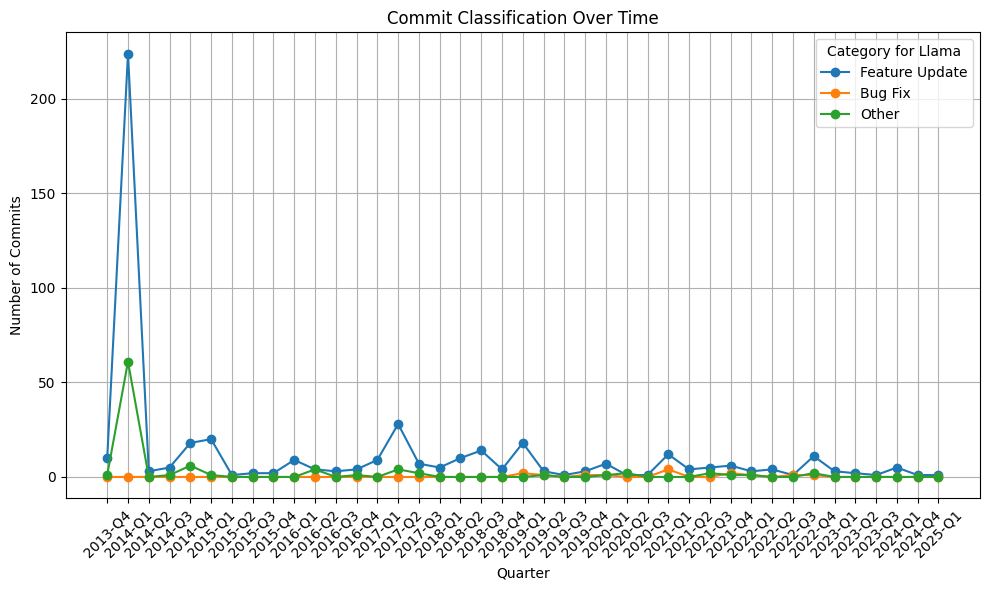

<Figure size 640x480 with 0 Axes>

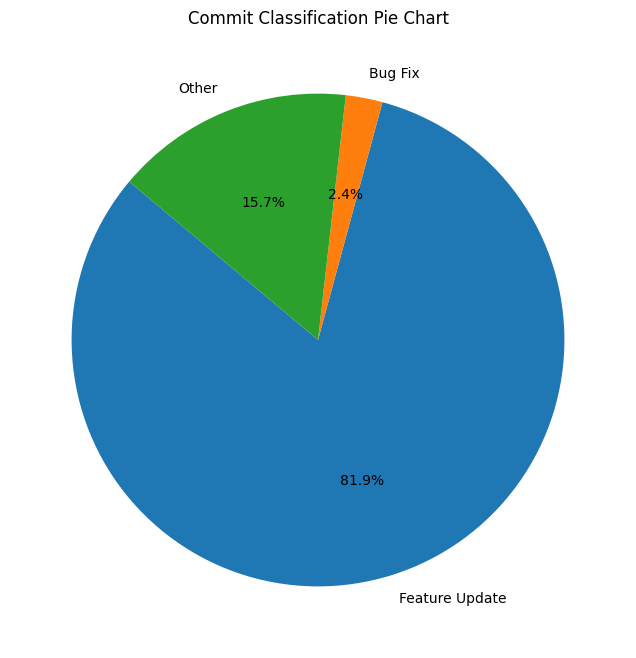

<Figure size 640x480 with 0 Axes>

In [ ]:
if commits_zero_shot is None:
  commits_zero_shot = copy.deepcopy(commits)

for i, (idx, commit) in tqdm(enumerate(commits_zero_shot.items())):
    # Run summarization and classification only on unprocessed commits
    #if not commit['llama_summary']:
      #prompt = generate_prompt_summarization(commit)
      #commit['llama_summary'] = ask_model_summarization(prompt, pipe_llama)
    if commit['llama_category']:
      prompt = generate_prompt_categorization_zero_shot(commit)
      commit['llama_category'] = ask_model_categorization(prompt, pipe_llama)
    save_commits(commits_zero_shot, full_path(current_directory,"zero_shot"))

plot_categories(commits_zero_shot, "zero_shot")
plot_categories_piechart(commits_zero_shot, "zero_shot")

## Technical analysis of commits
In this section I would like to use the architecture described in MAGIS to perform an iterative 'summary-evaluation of summary' for the technical aspect of the diffs.

In [ ]:
def generate_prompt_technical_analysis(commit, comment=None):
  """
  Generate the prompt for the technical analysis, if a comment from QA is present it is incorporated in the prompt.
  """

  prompt = f"""
        You are an expert developer and code reviewer. Analyze the following code diffs from a commit and provide a detailed technical explanation of the changes, including any potential impact on functionality, performance, or correctness.

        Use the following format:
        - **Summary of Changes**: A brief summary of the changes made in the diff.
        - **Functionality**: Describe how these changes affect the functionality of the code.
        - **Performance**: Mention any impact on performance, if applicable (e.g., optimizations, changes in computational complexity).
        - **Correctness**: Discuss any potential correctness issues or improvements.
        - **Other Considerations**: Any other relevant points, such as code style, readability, or maintainability.

        Example 1:
        Commit Informations:
        - Hash (unique identifier): a1b2c3d4
        - Author: John Doe
        - Date: 2025-01-01 10:00:00
        Commit Message - this provides a brief summary of the changes:
        Refactored the user authentication module to improve performance and readability.
        Changed Files - files modified in this commit:
        auth.py
        Diffs - lines of code changed in each file:
        auth.py:
        ```diff
        - def authenticate_user(username, password):
        -     if username and password:
        -         return check_credentials(username, password)
        + def authenticate_user(user_credentials):
        +     return validate_user(user_credentials)
        ```
        Summary of Changes: The `authenticate_user` function was refactored to accept a `user_credentials` object instead of separate `username` and `password` arguments.
        Functionality: This change simplifies the function interface, reducing the number of arguments and making it easier to maintain and extend.
        Performance: The performance impact is negligible, as the logic is functionally equivalent, but the refactor improves code readability.
        Correctness: No impact on correctness, assuming that `validate_user` is correctly implemented and that `user_credentials` contains all necessary data.
        Other Considerations: This change improves code maintainability by introducing a more modular approach to handling user authentication.

        Example 2:
        Commit Informations:
        - Hash (unique identifier): e5f6g7h8
        - Author: Alice Brown
        - Date: 2025-02-02 12:30:00
        Commit Message - this provides a brief summary of the changes:
        Fixed scope handling for function declarations in the JavaScript compiler.
        Changed Files - files modified in this commit:
        jscompiler.c
        Diffs - lines of code changed in each file:
        jscompiler.c:
        ```diff
        - static void compile_function_body(JF, js_Ast *name, js_Ast *params, js_Ast *body, int is_fun_exp);
        + static void compile_function_body(JF, js_Ast *name, js_Ast *params, js_Ast *body);
        - static js_Function *create_function(js_State *J, int line, js_Ast *name, js_Ast *params, js_Ast *body, int script, int strict, int is_fun_exp);
        + static js_Function *create_function(js_State *J, int line, js_Ast *name, js_Ast *params, js_Ast *body, int script, int strict);
        ```
        Summary of Changes: The `is_fun_exp` parameter was removed from both the `compile_function_body` and `create_function` functions to simplify function declaration handling.
        Functionality: This change refines how function declarations are processed, potentially avoiding issues with scope handling.
        Performance: The removal of the redundant parameter could improve the efficiency of function declaration processing, as fewer variables need to be managed.
        Correctness: The change is expected to improve correctness by adhering to the correct scoping rules for function declarations. There is no change to the behavior of the functions themselves.
        Other Considerations: This change contributes to cleaner and more maintainable code by simplifying the function declaration logic.

        Now analyze the following commit:

        Commit Informations:
        - Hash (unique identifier): {commit['hash']}
        - Author: {commit['author']}
        - Date: {commit['date'].strftime('%Y-%m-%d %H:%M:%S')}
        Commit Message - this provides a brief summary of the changes:
        {commit['message']}
        Changed Files - files modified in this commit:
        {', '.join(commit['files'])}
        Diffs - lines of code changed in each file:
        {chr(10).join([f"{file_name}: {diff[:1000]}" for file_name, diff in commit['diffs'].items()])}

        Provide a detailed technical analysis of the changes made, covering the following areas:
        - Summary of Changes
        - Functionality
        - Performance
        - Correctness
        - Other Considerations

        Do not repeat the prompt.
        {f"Follow this recommendations: {comment}" if comment else ''}

        Summary of Changes:
    """

  prompt = clean_text_paragraph(prompt)
  return prompt


def generate_quality_assurance_prompt(technical_summary):
    """
    Generate the QA prompt based on the technical summary.
    """
    prompt = f"""
    You are a quality assurance expert tasked with evaluating the technical summary of a commit. Below is the technical summary of the changes made in the commit:

    Your task is to evaluate the quality of the technical summary by assigning it a mark from **0 to 10** and providing feedback for improvement. Use the following guidelines for scoring:

    - **10**: The summary is flawless, thoroughly explains all key aspects, and includes exceptional clarity and insight.
    - **8-9**: The summary is clear, detailed, and mostly complete, with minor room for improvement.
    - **6-7**: The summary is adequate but lacks some details, clarity, or key insights.
    - **4-5**: The summary is incomplete or unclear in significant ways, requiring notable improvement.
    - **0-3**: The summary is severely lacking or inaccurate, failing to convey the purpose, impact, or details of the changes.

    Additionally, provide detailed feedback for improvement, regardless of the score. Highlight the strengths of the summary and suggest specific areas for clarification, expansion, or rephrasing.

    Answer Format:
    - Mark: <0-10>
    - Improvement Suggestions: <Provide detailed feedback, focusing on how to improve the summary or what makes it strong.>

    Example 1:
    Technical Summary:
    The commit introduces a refactor to the authentication module, which involves several key changes. Firstly, the `authenticate_user` function has been modified to support multi-factor authentication by adding a new `mfa_token` parameter. This change allows the system to require both a password and an additional MFA token for users to log in, improving security. Additionally, the function now checks the user's `mfa_status` before authentication and raises an error if MFA is required but not provided. This refactor also ensures backward compatibility, as users who do not have MFA enabled will continue to log in with just their password. Finally, related functions in the `user_session` and `security` modules have been updated to handle the new parameter appropriately. The change enhances overall security without sacrificing usability.

    Evaluation:
    - Mark: 9
    - Improvement Suggestions: The summary thoroughly explains the changes made, including the purpose behind adding MFA support and the backward compatibility considerations. It also outlines the modifications to the `user_session` and `security` modules. However, it could be beneficial to mention whether these changes require additional testing or updates to related systems like user management.

    Example 2:
    Technical Summary:
    This commit addresses a bug in the `calculate_total` function, where the system was not properly handling negative price values in the input list. The function previously did not have any validation for negative prices, which caused unexpected behavior when such prices were included in an order. As part of this fix, a new validation check has been added to ensure that all prices are non-negative before performing the calculation. If any negative price is detected, a `ValueError` is raised, and the calculation is aborted. This prevents the system from incorrectly processing orders with invalid prices and ensures that the order calculation remains accurate. This fix improves the integrity and correctness of the order processing system.

    Evaluation:
    - Mark: 7
    - Improvement Suggestions: The summary clearly explains the bug and how the fix prevents negative prices from being processed. It provides sufficient context on why this validation is necessary. However, it would be useful to briefly mention the impact of this fix on the user experience or checkout process. Also, elaborating on why negative prices were allowed in the first place could add more context.

    Example 3:
    Technical Summary:
    In this commit, the user profile creation process was refactored to streamline data handling. The user profile, which previously had separate fields for `settings` and `preferences`, has now been consolidated into a single `preferences` object. This change reduces the complexity of managing user preferences by grouping related data together, improving readability and maintainability. The new `preferences` object holds all settings, such as notification preferences, theme settings, and language preferences, making it easier to handle and update user data. This change is part of an ongoing effort to simplify the codebase and reduce the number of scattered data structures that need to be maintained.

    Evaluation:
    - Mark: 5
    - Improvement Suggestions: While the summary provides a clear explanation of the refactor, it could benefit from more context on how the change will impact the user experience or the way the user profile data is accessed in other parts of the system. The description is missing the rationale behind choosing to combine `settings` and `preferences` into a single object—this would help readers understand why this change is beneficial in the long run.

    Now, please evaluate the provided technical summary. Do not repeat the prompt.

    Technical Summary:
    {technical_summary}

    Answer:
    """
    prompt = clean_text_paragraph(prompt)
    return prompt


def ask_model_technical_analysis(prompt, pipe):
  answer = pipe(
      prompt,
      max_new_tokens= 500,
      do_sample=True,
      top_p = None,
      temperature= 0.7
  )[0]['generated_text']

  answer = answer.split("Summary of Changes:")[-1]
  return answer

def ask_model_quality_assurance(prompt, pipe):
  answer = pipe(
      prompt,
      max_new_tokens=500,  # Increased tokens
      do_sample=True,
      top_p=None,
      temperature=0.7
  )[0]['generated_text']

  answer = answer.split("Answer:")[-1]
  # Extract decision (True/False) and improvement suggestions (comment)
  lines = answer.strip().split("\n")

  # Find the line containing "Mark"
  mark_line = next((line for line in lines if "Mark" in line), None)
  if mark_line is not None:
    mark = mark_line.split(":")[-1].strip()
  else:
    mark = "-1"  # or some default value if not found

  # Find the line containing "Improvement Suggestions"
  improvement_suggestions_line = next((line for line in lines if "Improvement Suggestions" in line), None)
  if improvement_suggestions_line is not None:
    improvement_suggestions = improvement_suggestions_line.split(":")[-1].strip()
  else:
    improvement_suggestions = "No suggestions provided."  # or some default value


  return mark, improvement_suggestions


def generate_technical_report(commit):
  mark_qa = -1
  improvements = None
  technical_summary= None
  THRESHOLD = 9

  while int(mark_qa) < THRESHOLD:

    prompt = generate_prompt_technical_analysis(commit, improvements)
    technical_summary = ask_model_technical_analysis(prompt, pipe_llama)

    qa_prompt = generate_quality_assurance_prompt(technical_summary)
    mark_qa, improvements = ask_model_quality_assurance(qa_prompt, pipe_llama)

    print(f"Mark: {mark_qa}")
    print(f"Improvement suggestions: {improvements}")

  return technical_summary


## Run Technical reports generation

- few shots technical analysis

In [ ]:
for idx, (i, commit) in tqdm(enumerate(commits_few_shots.items())):
  if 'llama_tech_summary' not in commit:
    commit['llama_tech_summary'] = generate_technical_report(commit)
    #print(f"Processed commmit {idx+1}/{len(commits_few_shots)}")
  save_commits(commits_few_shots, full_path(current_directory,"few_shots"))


## User storyline Prompt functions

In [ ]:
def actors_functions_prompt_user_story_summarization_few_shot(commit):
    """
    Generate a prompt for summarizing a git commit.
    """
    prompt = f"""
                You are an expert assistant trained to extract user stories from technical requirements. A user story should clearly identify the "who," "what," and "why" of a requirement. Use the following structure:

                **User Story Structure:**
                **As a [role]**, I want [goal] so that [reason/benefit].

                **Example1**

                **Input:**
                "Issue 193 and issue 194: always use heapsort instead of quicksort. The quicksort implementation behaves badly when presented with non-deterministic comparison functions. The heapsort is more robust and has fewer edge cases to worry about in the face of an adversarial comparison function. These changes improve the robustness and reliability of the sorting algorithm, making it more suitable for real-world applications. The use of heapsort ensures that the algorithm is less prone to errors and provides a more predictable behavior, which is essential for applications that require high reliability and accuracy."

                **Output:**
                **developer** : I want to replace quicksort with heapsort so that the sorting algorithm is more robust and reliable in handling adversarial comparison functions.
                **tester** : I want to verify the robustness and predictability of heapsort so that the algorithm behaves as expected in real-world scenarios.
                **project manager** : I want to prioritize robustness and reliability over performance so that the project aligns with long-term goals and avoids potential critical issues.

                ---
                **Example2**

                **Input:**
                "Simplify array.prototype.sort by sorting in place without libc. This change improves performance by reducing the number of memory allocations and copies required. It also eliminates the risk of memory leaks due to exceptions thrown by the sorting function.

                **Output:**
                **JavaScript developer** : I want to simplify `array.prototype.sort` by sorting in place without `libc` so that I can reduce memory allocations and eliminate the risk of memory leaks.
                **performance engineer** : I want to optimize the JavaScript engine by implementing quicksort and heapsort so that it runs more efficiently in real-world applications.
                **software architect** : I want to establish a solid foundation for future optimizations in the JavaScript engine so that improvements can be built upon a reliable base.
                **tester** : I want to validate the new in-place sorting implementations so that they work correctly and reliably under various scenarios.

                ---
                **Example3**

                **Input:**
                "Issue #130: Fix a bug in string splitting that would cause an empty string to be returned when the input string is empty.

                **Output:**
                **developer** : I want to fix the bug in the `split` method so that it behaves correctly when handling empty strings.
                **tester** : I want to validate the behavior of the `split` method with empty input strings so that I can ensure it no longer returns incorrect results.
                **project manager** : I want to improve the robustness and reliability of the codebase so that the product delivers consistent and high-quality performance.
                **end-user** : I want the `split` method to work correctly even with edge cases like empty strings so that I can rely on it in all scenarios.

                ---

                Follow the above examples to extract user stories from similar technical descriptions, don't repeat the previous examples.
                Generate only the output.

                ---
                **Example4**

                **Input:**
                {commit}

                **Output:**
                """

    prompt = clean_text_paragraph(prompt)
    return prompt




def actors_functions_user_story_summarization_tech_few_shot(commit):
    """
    Generate a prompt for summarizing a git commit.
    """
    prompt = f"""
                  You are an expert assistant trained to extract actionable insights or user stories from technical summaries. A user story should clearly identify the "who," "what," and "why" of a requirement. Use the following structure:

                  **User Story Structure:**
                  **[role]**, I want [goal] so that [reason/benefit].

                  **Example1**

                  **Input:**
                  "The implementation of heapsort is merged into the quicksort implementation, replacing the original partitioning and selection steps.
                  Functionality: This change refines the comparison-based sorting algorithm, improving its robustness and performance.
                  Performance: The use of heapsort reduces computational complexity from O(n^2) to O(n log n), potentially improving overall system performance.
                  Correctness: The implementation is correct and does not introduce any new bugs.
                  Other Considerations: This change provides a more efficient and scalable sorting algorithm, suitable for large-scale applications.
                  Analysis of the differences between the two implementations:
                  - **Partitioning and Selection**: The original quicksort implementation used the "Lomuto" partition scheme, which is more suitable for data with a large number of distinct values. In contrast, the heapsort implementation uses the "Heapsort" algorithm, which is more efficient in scenarios with a large number of equal elements or when working with arrays of large size.
                  - **Comparison-based sorting**: The heapsort implementation uses a comparison-based sorting algorithm, which is more robust and less prone to issues like quicksort's worst-case time complexity. The use of an array-based sorting algorithm is likely to improve performance in applications with a high number of similar elements.
                  - **Scalability**: The heapsort implementation is more scalable than the quicksort implementation, as it can handle larger datasets without significant performance degradation. In comparison, quicksort's performance degrades rapidly as the dataset size increases.
                  - **Robustness**: The heapsort implementation is more robust than quicksort, reducing the likelihood of errors in performance-critical scenarios."

                  **Output:**
                  **developer** : I want to replace quicksort with heapsort in the sorting implementation so that the algorithm is more robust and performs consistently for large datasets.
                  **performance engineer** : I want to use heapsort in place of quicksort so that computational complexity is reduced from O(n^2) to O(n log n), leading to improved performance in real-world applications.
                  **software architect** : I want to implement heapsort for comparison-based sorting so that it scales effectively with larger datasets and handles scenarios with many similar elements more efficiently.
                  **tester** : I want to validate the correctness of the heapsort implementation so that it does not introduce new bugs while improving performance and robustness.

                  ---
                  **Example2**


                  **Input:**
                  "The `split` method in `jsstring.c` was refactored to return an empty value if the `limit` parameter is set to 0, rather than attempting to access the `b` and `p` variables when `len` is 0.
                  Functionality: This change addresses the issue of handling edge cases where the input string contains only one match.
                  Performance: The refactoring improves the performance by only returning an empty value when `limit` is 0, which reduces the amount of unnecessary computation.
                  Correctness: The function remains correct and handles all edge cases correctly, including the case where the input string contains only one match.
                  Other Considerations: The variable names could be improved for better readability, and a brief description of the function's purpose could be added to further explain its functionality. Additionally, a comment to address potential issues with Unicode characters could be added to ensure the function handles non-ASCII characters correctly."

                  **Output:**
                  **developer** : I want the split method to handle the limit=0 edge case so that it correctly returns an empty value without accessing invalid variables.
                  **software architect** : I want to refactor the split method to improve readability and maintainability so that future modifications are easier to implement.
                  **QA engineer** : I want to test the split method with Unicode and edge cases so that it handles non-ASCII characters and extreme input scenarios reliably.
                  **project manager** : I want to ensure the split method is optimized for performance in edge cases so that unnecessary computation is reduced.
                  ---
                  **Example3**
                   The changes modify the `utf.h` file to support Unicode characters by adding a `typedef` declaration for `Rune`, a `const char *` variable, and a `bool` flag. The `utf.h` file is also updated with a new function and a new macro.
                  Code Organization: The changes were made in the `utf.h` file, which is a header file that is included in several other C files. The `utf.h` file is updated to support Unicode characters by adding a `typedef` declaration for `Rune` and a new function.
                  Functionality: This change simplifies the way Unicode characters are represented in the `utf.h` file. The `utf.h` file now supports Unicode characters, including high surrogate pairs.
                  Performance: The performance impact of this change is negligible, as the logic is functionally equivalent, but the change improves code readability.s
                  Correctness: This change is correct, as it adheres to the Unicode character encoding standard. The `utf.h` file now supports Unicode characters, including high surrogate pairs.
                  Other Considerations: This change updates the code organization and improves code readability, making it easier to understand and maintain. The use of a `typedef` declaration for `Rune` and the new function and macro in the `utf.h` file make it easier to implement and use Unicode characters.

                  **Output:**
                  **developer** : I want to update the utf.h file to support Unicode characters so that the codebase can handle a wider range of characters, including high surrogate pairs.
                  **software architect** : I want to improve the code organization in the utf.h file by adding the typedef declaration for Rune, a new function, and a macro so that the code is more readable and maintainable for handling Unicode characters.
                  **performance engineer** : I want to ensure that the updates to utf.h do not introduce performance bottlenecks so that the system remains efficient while supporting Unicode characters.
                  **tester** : I want to validate that the changes to utf.h correctly handle Unicode characters, including high surrogate pairs, so that the application supports a wider range of text inputs.
                  **project manager** : I want to ensure that the changes in utf.h align with the project goals of improving code readability and supporting Unicode so that the codebase is more maintainable and scalable.


                  Follow the above examples to extract user stories from similar technical descriptions, don't repeat the previous examples.
                  Generate only the output.
                  ---
                  **Example4**

                  # **Input:**
                  {commit}

                  **Output:**
                """
    prompt = clean_text_paragraph(prompt)
    return prompt


def ask_model_user_story(prompt, pipe):
    """
    Ask the model to summarize a git commit.
    """
    answer = pipe(
        prompt,
        max_new_tokens=2000,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
    )[0]['generated_text']

    answer = answer.split("**Output:**")[-1]
    return answer

In [ ]:
def prompt_story_summary(role, pair):
    """
    Generate a prompt for summarizing a git commit.
    """

    prompt = f"""
    Create a short story where the main character plays the role of a [ROLE]. The character takes the following action: [ACTION].
    The reason for this action is: [REASON/BENEFIT]. The story should be concise, focusing on how the character’s action leads to a positive outcome.

      **Example1**
    **Input**
    performance engineer':
    ('I want to optimize the JavaScript engine by implementing quicksort and heapsort','so that it runs more efficiently in real-world applications.')

    **Output**
    The performance engineer examined the JavaScript engine, looking for ways to boost efficiency. "I want to optimize the engine by implementing quicksort and heapsort," he thought. "This will make it run more efficiently in real-world applications."
    The engine had been functional, but the sorting algorithms it relied on were slowing things down. By adding quicksort for most cases and heapsort for edge cases, the engineer could significantly improve performance.
    After implementing the changes, the engine ran faster and handled larger, more complex tasks with ease. The engineer tested it in real-world scenarios, satisfied that the optimization would make a noticeable difference in everyday applications.


    **Example2**
    **Input**
    'JavaScript developer':
    ('I want to simplify array.prototype.sort by sorting in place without libc','so that I can reduce memory allocations and eliminate the risk of memory leaks.')

    **Output**
    The JavaScript developer looked at the array.prototype.sort function and thought, "I want to simplify this by sorting in place without using libc, so that I can reduce memory
    allocations and eliminate the risk of memory leaks."
    The current sorting method was efficient but relied on external libraries that introduced unnecessary memory usage and potential leaks.
    By sorting in place, the developer could eliminate this risk and improve overall performance.
    After modifying the implementation, the developer tested it with various data sets. The results were clear: memory usage was reduced,
    and the system ran more efficiently. The developer smiled, knowing the change would make the codebase more reliable.

    **Example3**
    'project manager':
    ('I want to ensure that the changes in utf.h align with the project goals of improving code readability and supporting Unicode', 'so that the codebase is more maintainable and scalable.')

    **Output**
    The project manager gathered the team for a quick meeting. "I want to prioritize the maintenance of the compiler's behavior over performance considerations," he explained. "This will help align with our long-term goals."
    The team had been discussing optimizations that could speed up the compiler, but the manager knew that stability and predictability were more important for the project’s future. By focusing on maintaining consistent behavior, they could ensure that the compiler would remain reliable as new features were added.
    With the direction set, the team agreed to focus on the long-term vision, knowing that performance improvements could always come later without compromising the compiler's core functionality.

    Follow the above examples to extract user stories from similar technical descriptions, don't repeat the previous examples.
    Generate only the output.
    ---
    **Example4**

    # **Input:**
    '{role}':
    ({pair})

    **Output:**
    """
    prompt = clean_text_paragraph(prompt)
    return prompt

In [ ]:
def prompt_story_summary_tech(role, pair):
    """
    Generate a prompt for summarizing a git commit.
    """

    prompt = f"""
    Create a short story where the main character plays the role of a [ROLE]. The character takes the following action: [ACTION].
    The reason for this action is: [REASON/BENEFIT]. The story should be concise, focusing on how the character’s action leads to a positive outcome.

    **Example1**
    **Input**
    'developer':
    ('I want to refactor the quicksort implementation to use heapsort,','so that it becomes more efficient and scalable for various scenarios.')

    **Output**
     The developer stared at the quicksort implementation, knowing it had its limits. "I want to refactor the quicksort implementation to use heapsort," he said.
     "This will make it more efficient and scalable for various scenarios. "Quicksort had worked fine for most cases, but in extreme scenarios, its performance faltered.
     Heapsort, with its consistent time complexity and low memory usage, would solve these issues. He quickly refactored the code, replacing quicksort with heapsort.
     The system now handled large datasets with ease, running faster and using less memory. The developer smiled, satisfied with the improvements, knowing that the
     change would make the system ready for anything.


    **Example2**
    **Input**
    'software architect':
    ('I want to implement a simple quicksort for small fragments in jsgc.c', 'so that it can be used as a replacement for qsort.')

    **Output**
    The software architect reviewed the code in jsgc.c and muttered to himself, "I want to implement a simple quicksort for small fragments here, so that it can be used as a replacement for qsort."
    He knew qsort was effective, but it came with overhead that wasn't necessary for small data sets. A simpler, more efficient quicksort would improve the system's performance by
    reducing unnecessary complexity. With a few keystrokes, he crafted a streamlined quicksort, tailored for small fragments. The change was small, but it made a big difference:
    the new quicksort sped up processing without the overhead of qsort. The architect tested the system, and the results were clear—performance had improved.

    **Example3**
    'project manager':
    ('I want to ensure that the changes in utf.h align with the project goals of improving code readability and supporting Unicode', 'so that the codebase is more maintainable and scalable.')

    **Output**
    The project manager reviewed the changes in utf.h and said, "I want to ensure that these changes align with our project goals of improving code readability and supporting Unicode,
    so that the codebase is more maintainable and scalable." The manager knew that improving readability would help current and future developers navigate the code with ease,
    while ensuring full Unicode support would make the system adaptable to a broader range of languages and characters. With the team aligned on these goals, the changes were carefully
    implemented, making the codebase cleaner, more flexible, and ready for future growth. The manager felt confident knowing the project was on the right track for long-term success.

    Follow the above examples to extract user stories from similar technical descriptions, don't repeat the previous examples.
    Generate only the output.
    ---
    **Example4**

    # **Input:**
    '{role}':
    {pair}

    **Output:**
    """
    prompt = clean_text_paragraph(prompt)
    return prompt


In [ ]:
def remove_stars(input_string):
    """
    Removes all asterisk (*) characters from the given string.

    Parameters:
        input_string (str): The string to process.

    Returns:
        str: The string without any asterisk characters.
    """
    return input_string.replace('*', '')

In [ ]:
def create_role_dict(user_stories):                #### we do not consider the lines without so that
    role_dict = {}
    line = user_stories.split("\n")
    for story in line:
          try:                                     ### if the row is not set properly is discarded
            role = remove_stars(story.split(" : ")[0].strip())
            action_benefit = story.split(" : ")[1].strip()
            action = action_benefit.split(" so that ")[0].strip()
            benefit = action_benefit.split(" so that ")[1].strip()
            if role not in role_dict:
                role_dict[role] = []

            role_dict[role].append((f"I want {action}", f"so that {benefit}"))

          except IndexError as e:
            continue
    return role_dict

In [ ]:
def ask_model_final_user_story(prompt, pipe):
    """
    Ask the model to summarize a git commit.
    """
    answer = pipe(
        prompt,
        max_new_tokens=5000,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
    )[0]['generated_text']

    answer = answer.split("**Output:**")[-1]
    return answer

In [ ]:
##### USING MORE EXAMPLE IS MISSLEADING FOR THE MODEL
def create_compound_story_prompt(actor, story1, story2):
    prompt = f"""
        **Instruction**
        Combine the key points from both stories into a **single, cohesive narrative**. Focus on highlighting the roles and contributions of the characters involved, ensuring that their efforts are logically connected and complement each other. Emphasize collaboration and the impact of their work on the overall success of the project.
        - Keep the narrative concise and precise.
        - Avoid repeating ideas or sentences.
        - Ensure a smooth flow, maintaining clarity and engagement throughout.

        **Example 1**
        **Input**
        Actor: developer
        Story 1: The developer examined the implementation of array.prototype.sort. "I want to simplify this by removing the libc dependency and implementing a simple quicksort with insertion sort for small fragments," he thought. "This will improve performance."
        The current sorting method was efficient but relied on external libraries that introduced unnecessary memory usage and potential leaks.
        By simplifying the implementation, the developer could eliminate this risk and improve overall performance.
        After modifying the code, the developer tested it with various data sets. The results showed significant improvements in performance. The developer was satisfied that the changes would make the codebase more reliable.
        Story 2: The UX designer reviewed the new UI element designs and thought, "I want to ensure that the visual design aligns with the project's brand guidelines."
        The designer had been tasked with creating the new UI elements, but the project's brand guidelines were still being finalized. By focusing on ensuring consistency with the guidelines, the designer could create visually appealing and cohesive designs.
        After reviewing the designs, the designer made adjustments to ensure that the new UI elements aligned with the brand guidelines. The result was a cohesive and consistent visual design that met the project's standards.

        **Output**
        The developer examined the implementation of array.prototype.sort with a clear goal: "I want to simplify this by removing the libc dependency and implementing a quicksort with insertion sort for small fragments." Simplifying the method would reduce memory usage and eliminate potential risks from external libraries.
        After refactoring the code, the developer tested it extensively with various datasets. The results showed improved performance and reliability, confirming the changes were effective.
        Just as the UX designer refined UI elements to align with brand guidelines, the developer’s meticulous work ensured the sorting method was both efficient and dependable, contributing to a more robust codebase.

        **Example 2**
        **Input**
        Actor: tester
        Story 1: The manager evaluated the new sorting algorithm, considering its cost-effectiveness and scalability. "I want to ensure that it meets the project's budget and resource requirements," he thought. "This will help us allocate resources efficiently and make informed decisions."
        The manager analyzed the algorithm's performance and cost-benefit analysis, searching for opportunities to optimize its resource usage. By verifying the algorithm's cost-effectiveness, the manager could identify potential issues that could compromise the project's budget and resource allocation.
        With the cost-benefit analysis complete, the manager reported back to the developers, highlighting the need for further optimization to meet the project's specific requirements.
        Story 2: The tester looked at the `split` method and thought, "I want to validate this behavior by testing it with empty input strings."
        The current implementation had been working fine, but the tester knew that edge cases could lead to unexpected results.
        To test the method, the tester created test cases with empty strings and verified that the function returned the expected results. With this validation, the tester could ensure that the `split` method was working correctly.
        After implementing the test, the tester tested the method with various input scenarios. The results were clear: the `split` method returned the correct results in all cases.
        The tester was satisfied that the validation would help improve the method's reliability.

        **Output**
        The tester, aware of the manager's focus on cost-effectiveness and scalability for the sorting algorithm, turned their attention to validating the split method. "I need to ensure this works with all inputs," they thought, considering edge cases like empty strings.
        They quickly created test cases, focusing on scenarios that might cause errors, and ran them. The method passed each one flawlessly, confirming its reliability.
        Just as the manager optimized the algorithm’s resources, the tester optimized for precision, ensuring the method would perform smoothly across all scenarios, contributing to the project's success.

        **Example 3**
        **Input**
        Actor: end-user
        Story 1: The manager gathered the team for a meeting. "I want the development time to be reduced," he said. "This will enable us to implement and test new features more quickly." The team discussed the challenges of implementing new features, but the manager knew that speed was essential.
        By introducing more efficient development processes and tools, the manager could ensure that new features were implemented and tested faster, without compromising quality. With the direction set, the team agreed to focus on implementing the new features, knowing that speed would be crucial in the future.
        Story 2: The quality assurance engineer wanted to implement the filter method with correct edge cases, ensuring it works as expected in various scenarios.

        **Output**
        The manager gathered the team for a meeting. "I want the development time to be reduced," he said. "This will enable us to implement and test new features more quickly." The team discussed the challenges of balancing speed and quality, but the manager was resolute. He knew that in order to stay competitive, they had to move faster without compromising the integrity of their work.
        At the same time, the quality assurance engineer was working hard on implementing the filter method. She understood how important it was to cover all edge cases, ensuring it worked as expected across a variety of scenarios. She was meticulous, knowing that testing thoroughly would save time in the long run by preventing bugs from slipping through.
        As the manager continued to push for faster development, the engineer made sure to focus on detail and accuracy in her work. Together, their collaboration allowed the team to meet the challenge—implementing new features quickly while maintaining high standards.

        **Input**
        Actor: {actor}
        Story 1: {story1}
        Story 2: {story2}

        **Output**
        Create a unified, engaging story that combines the key elements of both inputs into one cohesive narrative. Avoid unnecessary details or filler content, ensuring the final output is clear and impactful.\n"""

    prompt = clean_text_paragraph(prompt)
    return prompt

In [ ]:
def create_compound_story_prompt(actor, story1, story2):
    prompt = f"""
        **Instruction**
        Combine the key points from both stories into a **single, cohesive narrative**. Focus on highlighting the roles and contributions of the characters involved, ensuring that their efforts are logically connected and complement each other. Emphasize collaboration and the impact of their work on the overall success of the project.
        - Keep the narrative concise and precise.
        - Avoid repeating ideas or sentences.
        - Ensure a smooth flow, maintaining clarity and engagement throughout.

        **Example 1**
        **Input**
        Actor: developer
        Story 1: The developer examined the implementation of array.prototype.sort. "I want to simplify this by removing the libc dependency and implementing a simple quicksort with insertion sort for small fragments," he thought. "This will improve performance."
        The current sorting method was efficient but relied on external libraries that introduced unnecessary memory usage and potential leaks.
        By simplifying the implementation, the developer could eliminate this risk and improve overall performance.
        After modifying the code, the developer tested it with various data sets. The results showed significant improvements in performance. The developer was satisfied that the changes would make the codebase more reliable.
        Story 2: The UX designer reviewed the new UI element designs and thought, "I want to ensure that the visual design aligns with the project's brand guidelines."
        The designer had been tasked with creating the new UI elements, but the project's brand guidelines were still being finalized. By focusing on ensuring consistency with the guidelines, the designer could create visually appealing and cohesive designs.
        After reviewing the designs, the designer made adjustments to ensure that the new UI elements aligned with the brand guidelines. The result was a cohesive and consistent visual design that met the project's standards.

        **Output**
        The developer examined the implementation of array.prototype.sort with a clear goal: "I want to simplify this by removing the libc dependency and implementing a quicksort with insertion sort for small fragments." Simplifying the method would reduce memory usage and eliminate potential risks from external libraries.
        After refactoring the code, the developer tested it extensively with various datasets. The results showed improved performance and reliability, confirming the changes were effective.
        Just as the UX designer refined UI elements to align with brand guidelines, the developer’s meticulous work ensured the sorting method was both efficient and dependable, contributing to a more robust codebase.

        **Input**
        Actor: {actor}
        Story 1: {story1}
        Story 2: {story2}

        **Output**
        Create a unified, engaging story that combines the key elements of both inputs into one cohesive narrative. Avoid unnecessary details or filler content, ensuring the final output is clear and impactful.\n"""

    prompt = clean_text_paragraph(prompt)
    return prompt

## CREATION USER STORY

In [ ]:
DATA_FILEPATH_FEW_SHOTS = 'commits_few_shots_with_dictionary_story.pkl'##### Open the right file   #### DELETE AT MOST USING ONLY RAW DATA

commits_few_shots = load_commits(DATA_FILEPATH_FEW_SHOTS) # To resume experiments


Creation dictionary with Role : [ ( action , benefit/reason ) ]

In [ ]:
for  idx, (i, commit) in tqdm(enumerate(commits_few_shots.items())):
  if(idx>10):
      break
  if 'dict_role_action_sum' not in commit and "dict_role_action_sum_tech" not in commit:
    author = commit["author"]
    prompt_summarization = actors_functions_prompt_user_story_summarization_few_shot(commit["llama_summary"])
    prompt_tech_summarization = actors_functions_user_story_summarization_tech_few_shot(commit["llama_tech_summary"])
    roles_extracted_summ_few_shots =  ask_model_user_story(prompt_summarization, pipe_llama).strip()
    roles_extracted_summ_tech_few_shots =  ask_model_user_story(prompt_tech_summarization, pipe_llama).strip()

    dict_role_action_sum = create_role_dict(roles_extracted_summ_few_shots)
    dict_role_action_sum_tech = create_role_dict(roles_extracted_summ_tech_few_shots)

    # SAVE IN COMMIT DATA
    commit["dict_role_action_sum"] = dict_role_action_sum
    commit["dict_role_action_sum_tech"] = dict_role_action_sum_tech

  save_commits(commits_few_shots, full_path(current_directory,"few_shots"))


11it [00:09,  1.22it/s]


Create Role : Story


In [ ]:
#### from dictionary role-action to role-story
for  idx, (i, commit) in tqdm(enumerate(commits_few_shots.items())):
  if(idx>10):
      break
  if 'actor_story_tech' not in commit and "actor_story_sum" not in commit:
    author = commit["author"]
    dict_sum = {}

    for k , v in commit["dict_role_action_sum"].items():
      array_story = []
      for el in v:
        prompt_sum = prompt_story_summary(k, el)
        story = ask_model_user_story(prompt_sum, pipe_llama).strip()
        array_story.append(story)

      dict_sum[k] = array_story
    commit["actor_story_sum"] = dict_sum

    dict_tech_sum = {}
    for k , v in commit["dict_role_action_sum_tech"].items():
      array_tech_story = []
      for el in v:
        prompt_sum_tech = prompt_story_summary_tech(k, el)
        story = ask_model_user_story(prompt_sum_tech, pipe_llama).strip()
        array_tech_story.append(story)

      dict_tech_sum[k] = array_tech_story
    commit["actor_story_tech"] = dict_tech_sum

  save_commits(commits_few_shots, full_path(current_directory,"few_shots"))

11it [00:31,  2.85s/it]


In [ ]:
list_authors =set()

for index in commits_few_shots:
  list_authors.add(commits_few_shots[index]["author"])

story_authors = { a : { "summary": {} ,"tech_sum":  {} } for a in list_authors }

story_authors

{'Szabolcs Nagy <nsz@port70.net>': {'summary': {}, 'tech_sum': {}},
 'Sebastian Rasmussen <sebras@gmail.com>': {'summary': {}, 'tech_sum': {}},
 'Robin Watts <robin.watts@artifex.com>': {'summary': {}, 'tech_sum': {}},
 'Tor Andersson <tor.andersson@gmail.com>': {'summary': {}, 'tech_sum': {}},
 'Tor Andersson <tor.andersson@artifex.com>': {'summary': {}, 'tech_sum': {}},
 'gardhr <24468810+gardhr@users.noreply.github.com>': {'summary': {},
  'tech_sum': {}},
 'Tor Andersson <tor@ccxvii.net>': {'summary': {}, 'tech_sum': {}},
 'Ismael Luceno <ismael@iodev.co.uk>': {'summary': {}, 'tech_sum': {}},
 'Avi Halachmi (:avih) <avihpit@yahoo.com>': {'summary': {}, 'tech_sum': {}},
 '李通洲 <carter.li@eoitek.com>': {'summary': {}, 'tech_sum': {}}}

Upload file in dictionary

In [ ]:
for  idx, (i, commit) in tqdm(enumerate(commits_few_shots.items())):
   if(idx<=9):
    author = commit["author"]
    for k, v in commit["actor_story_sum"].items():
      if k not in story_authors[author]["summary"].keys():
        story_authors[author]["summary"][k] = [v]

      else:
        story_authors[author]["summary"][k].append(v)


    for k, v in commit["actor_story_tech"].items():
      if k not in story_authors[author]["tech_sum"].keys():
        story_authors[author]["tech_sum"][k] = [v]
      else:
        story_authors[author]["tech_sum"][k].append(v)

for authors , sum_and_tech in story_authors.items():
  for summ_or_tech , dict_role_story in sum_and_tech.items():
    for role, stories in dict_role_story.items():
      unique_list = []
      for item in stories:
          if item not in unique_list:
              unique_list.append(item)
      story_authors[authors][summ_or_tech][role]= unique_list

580it [00:00, 543983.97it/s]


In [ ]:
save_variable(story_authors, full_path(current_directory,"story_authors"))

Variable saved to /content/commits_story_authors.pkl


In [ ]:
DATA_FILEPATH_FEW_SHOTS = 'commits_story_authors_dictvariable_with sotry.pkl'##### Open the right file   #### DELETE AT MOST USING ONLY RAW DATA

story_authors = load_commits(DATA_FILEPATH_FEW_SHOTS) # To resume experiments


## Function create story from role - action - benefit

Get complete story per Role

In [ ]:
DATA_FILEPATH_FEW_SHOTS = 'commits_complete_story_authors_concatenated.pkl'##### Open the right file   #### DELETE AT MOST USING ONLY RAW DATA

deep_story_authors = load_commits(DATA_FILEPATH_FEW_SHOTS) # To resume experiments

In [ ]:
deep_story_authors = copy.deepcopy(story_authors)

In [ ]:
for authors , sum_and_tech in story_authors.items():
  for summ_or_tech , dict_role_story in sum_and_tech.items():
    for role, stories in dict_role_story.items():
      complete_final_story = ''
      for story in stories:
        complete_final_story += story[0]
      deep_story_authors[authors][summ_or_tech][role] = complete_final_story


In [ ]:
save_variable(deep_story_authors, full_path(current_directory,"complete_story_authors"))

Variable saved to /content/commits_complete_story_authors.pkl


In [ ]:
DATA_FILEPATH_FEW_SHOTS = 'commits_complete_story_authors_concatenated.pkl'##### Open the right file   #### DELETE AT MOST USING ONLY RAW DATA

deep_story_authors = load_commits(DATA_FILEPATH_FEW_SHOTS) # To resume experiments


Get Story in Run Time
- use this method only for one author and one role

In [ ]:
#### Extract one role at random and create the story run-time, compare using its completes

In [ ]:
deep_run_time_story_authors = copy.deepcopy(story_authors)

In [ ]:
## ONLY USING THE SAMPLE OF Tor Andersson <tor.andersson@artifex.com>
for authors , sum_and_tech in run_time.items():
  for summ_or_tech , dict_role_story in sum_and_tech.items():
    for role, stories in dict_role_story.items():
      final_story =''
      for story in stories:
        prompt_final_story = create_compound_story_prompt(role, final_story, story)
        final_story = ask_model_final_user_story(prompt_final_story, pipe_llama)
      run_time[authors][summ_or_tech][role] = final_story
      save_variable(run_time, full_path(current_directory,"run_time_story_authors"))


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Variable saved to /content/commits_run_time_story_authors.pkl
Variable saved to /content/commits_run_time_story_authors.pkl


In [ ]:
#### COMPUTATIONAL EXPENSIVE USE SPECIFIC STORY
for authors , sum_and_tech in story_authors.items():
  for summ_or_tech , dict_role_story in sum_and_tech.items():
    for role, stories in dict_role_story.items():
      final_story =''
      for story in stories:
        prompt_final_story = create_compound_story_prompt(role, final_story, story)
        final_story = ask_model_final_user_story(prompt_final_story, pipe_llama)
      deep_run_time_story_authors[authors][summ_or_tech][role] = final_story
      save_variable(deep_run_time_story_authors, full_path(current_directory,"run_time_story_authors"))


**User** story line few-shot commit - SAVE IN FILES

## Evaluation


- creation of a vector ground truth of 100 elements

1.   List item
2.   List item



In [ ]:
category_dict = {i: category for i, category in enumerate(CATEGORIES)}


def get_number_from_keyboard():
    global category_dict
    while True:
        try:
            # Prompt user for input
            user_input = int(input(f"Enter a number between 0 and {len(category_dict)-1}: "))

            # Check if input is in the valid range
            if 0 <= user_input <= len(category_dict)-1:
                print(f"You entered a valid number: {user_input}")
                return user_input  # Return the valid input
            else:
                print("Invalid input. Please enter a number between 0 and {len(category_dict)}.")
        except ValueError:
            # Handle non-integer inputs
            print("Invalid input. Please enter a valid number.")


In [ ]:
ground_truth_array = [
  "Performance Improvement", "Performance Improvement", "Bug Fix", "Feature Update", "Bug Fix", "Performance Improvement", "Performance Improvement",
  "Bug Fix", "Bug Fix", "Feature Update", "Feature Update", "Refactoring", "Feature Update", "Bug Fix", "Feature Update", "Feature Update", "Feature Update",
  "Refactoring", "Bug Fix", "Feature Update", "Bug Fix", "Bug Fix", "Refactoring", "Bug Fix", "Feature Update", "Bug Fix", "Feature Update", "Feature Update",
  "Refactoring", "Feature Update", "Bug Fix", "Bug Fix", "Feature Update", "Bug Fix", "Bug Fix" ,"Bug Fix", "Feature Update", "Performance Improvement", "Bug Fix",
  "Bug Fix", "Bug Fix", "Build/CI Change", "Bug Fix", "Bug Fix", "Bug Fix", "Feature Update", "Feature Update", "Bug Fix", "Bug Fix", "Bug Fix", "Bug Fix", "Feature Update",
  "Other", "Bug Fix", "Bug Fix", "Refactoring", "Feature Update", "Bug Fix", "Feature Update", "Feature Update", "Performance Improvement", "Performance Improvement",
  "Feature Update", "Build/CI Change", "Feature Update", "Bug Fix", "Bug Fix", "Bug Fix", "Bug Fix", "Feature Update", "Bug Fix", "Bug Fix", "Bug Fix", "Bug Fix", "Bug Fix",
  "Feature Update", "Performance Improvement", "Bug Fix", "Feature Update", "Feature Update", "Performance Improvement", "Bug Fix", "Bug Fix", "Bug Fix", "Bug Fix", "Bug Fix",
  "Feature Update", "Feature Update", "Feature Update", "Bug Fix", "Feature Update", "Bug Fix", "Bug Fix", "Bug Fix", "Feature Update", "Bug Fix", "Bug Fix", "Bug Fix",
  "Feature Update", "Refactoring"
]

len(ground_truth_array)

100

## Create label 100 commit

In [ ]:
def process_chunk_and_get_ground_truth(commit_few_shot, chunk_size=100):
    global category_dict
    # Get a random starting index for the chunk (must be between 0 and len(commit_few_shot) - chunk_size)
    #start_index = random.randint(0, len(commit_few_shot) - chunk_size)
    print()
    start_index = 0
    ground_truth_array = np.zeros(chunk_size)
    # Select a chunk of 100 consecutive elements starting from the random index
    chunk = {key: commit_few_shot[key] for key in range(start_index, start_index + chunk_size)}

    # Loop through the chunk and process each entry
    for i, (arr_v, v) in enumerate(zip(ground_truth_array, chunk.values())):
        print(category_dict)
        print(v["llama_summary"])

        # Get a category from the user input
        number = get_number_from_keyboard()

        # Update ground_truth_array with the selected category
        ground_truth_array[i] = category_dict[number]
        print()

    return ground_truth_array

ground_truth = process_chunk_and_get_ground_truth(commits_few_shots)
save_variable(ground_truth, f"ground_truth_array_from{start_index}")

In [ ]:
def calculate_precision_recall_categorization(commits, ground_truth):
  """
  Returns the precision and recall of the commits.
  Note that ground_truth is a list where ground_truth[i] is the category of the i-th commit.
  Should be handcrafted or GPT generated.
  """

  TP = 0
  TN = 0
  FP = 0
  FN = 0

  for i, commit in commits.items():
    if i >= 100:
      break
    predicted = commit['llama_category']
    actual = ground_truth[i]
    if predicted == actual:
      if predicted == 'Other':
        TN += 1
      else:
        TP += 1
    else:
      if predicted == 'Other':
        FN += 1
      else:
        FP += 1

  accuracy = (TP + TN) / (TP + TN + FP + FN)
  precision = TP / (TP + FP) if TP + FP > 0 else 0
  recall = TP / (TP + FN) if TP + FN > 0 else 0

  return precision, recall, accuracy

In [ ]:
p, r, a = calculate_precision_recall_categorization(commits_few_shots, ground_truth_array)
print("Few-shots categorization performance")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"Accuracy: {a}")

Few-shots categorization performance
Precision: 0.5932203389830508
Recall: 0.4666666666666667
Accuracy: 0.36


In [ ]:
p, r, a = calculate_precision_recall_categorization(commits_zero_shot, ground_truth_array)
print("Zero-shot categorization performance")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"Accuracy: {a}")

Zero-shot categorization performance
Precision: 0.4444444444444444
Recall: 0.8
Accuracy: 0.4


## Evaluation Criteria for Summaries

Here are the key points to evaluate commit summaries systematically:

---

#### **1. Unambiguous**
- **Description**: Assesses whether the summary is clear and free of ambiguity. There should be no room for multiple interpretations, and the reader should immediately understand the changes described.  
- **Scoring**:  
  - **1**: Highly ambiguous, difficult to understand.  
  - **5**: Crystal clear and leaves no room for doubt.

---

#### **2. Informative**
- **Description**: Evaluates how much relevant information is provided in the summary. The reader should be able to understand the changes, context, and purpose without needing to look at the code itself.  
- **Scoring**:  
  - **1**: Lacks necessary details; vague or unhelpful.  
  - **5**: Rich in relevant information and fully descriptive.

---

#### **3. Significant**
- **Description**: Measures the impact or importance of the changes described. A significant summary highlights meaningful improvements, bug fixes, or optimizations that contribute value to the project.  
- **Scoring**:  
  - **1**: Insignificant or trivial changes with minimal impact.  
  - **5**: Highly impactful and meaningful.

---

#### **4. Coherent**
- **Description**: Examines the logical flow and readability of the summary. The summary should be well-structured, easy to follow, and written in a consistent style.  
- **Scoring**:  
  - **1**: Disorganized and difficult to read.  
  - **5**: Highly organized, logical, and professionally written.

---

In [ ]:
# UISC scores computed with GPT, reporting scores for few shot llama_summary

UISC_summary = [
    [5, 5, 5, 4], [5, 5, 5, 5], [4, 4, 4, 4], [5, 5, 5, 4], [5, 4, 5, 5],
    [4, 4, 3, 5], [2, 3, 3, 2], [5, 4, 5, 5], [5, 3, 5, 5], [5, 4, 5, 5],
    [3, 3, 5, 5], [4, 3, 4, 5], [4, 3, 5, 5], [2, 3, 3, 3], [3, 2, 3, 4],
    [3, 4, 3, 4], [4, 3, 4, 4], [3, 3, 4, 2], [4, 3, 3, 5], [3, 3, 3, 5],
    [5, 5, 5, 5], [4, 4, 3, 5], [3, 3, 2, 4], [4, 2, 3, 3], [4, 3, 5, 4],
    [4, 3, 5, 4], [5, 4, 4, 5], [5, 4, 4, 5], [5, 4, 3, 5], [3, 2, 4, 3],
    [5, 3, 5, 5], [5, 4, 5, 5], [5, 4, 5, 5], [5, 4, 5, 5], [2, 3, 4, 3],
    [3, 4, 4, 4], [2, 3, 4, 3], [5, 4, 5, 5], [5, 4, 5, 5], [4, 3, 5, 4],
    [3, 2, 4, 4], [4, 3, 5, 5], [4, 4, 4, 5], [3, 4, 3, 5], [5, 5, 4, 5],
    [4, 3, 3, 4], [5, 4, 5, 5], [5, 4, 5, 5], [5, 4, 5, 5], [3, 2, 4, 3],
    [3, 2, 3, 3], [4, 3, 3, 3], [5, 4, 5, 5], [5, 4, 5, 5], [4, 4, 3, 5],
    [4, 4, 4, 5], [4, 4, 5, 5], [5, 4, 3, 5], [5, 4, 4, 4], [3, 3, 4, 4],
    [4, 4, 5, 5], [2, 3, 2, 2], [3, 3, 4, 4], [2, 2, 3, 3], [3, 3, 4, 4],
    [3, 3, 4, 4], [4, 4, 4, 5], [3, 4, 3, 4], [4, 4, 4, 5], [4, 3, 4, 4],
    [3, 3, 4, 3], [2, 3, 3, 3], [3, 4, 4, 4], [4, 4, 4, 4], [4, 3, 5, 4],
    [3, 2, 4, 3], [5, 4, 3, 5], [5, 5, 4, 5], [1, 1, 1, 2], [4, 4, 5, 5],
    [3, 3, 4, 3], [4, 3, 4, 5], [4, 3, 4, 5], [3, 4, 3, 4], [4, 4, 4, 5],
    [5, 5, 5, 5], [4, 4, 4, 4], [3, 4, 3, 4], [3, 4, 4, 4], [4, 3, 4, 4],
    [4, 3, 4, 4], [4, 4, 4, 5], [3, 3, 5, 4], [5, 4, 4, 4], [5, 5, 5, 5],
    [2, 3, 4, 3], [3, 4, 4, 4], [2, 3, 4, 3], [5, 5, 5, 5], [5, 5, 5, 5]
]

## Summarization performance

We set three different threshold for the UISC metric:
- T = 12. mediocre summary
- T = 14, good summary
- T = 17, excellent summary

In [ ]:
THRESHOLDS = [12, 17]
print("Few-shots commit summarization performance:")
count_mediocre = 0
count_good=0
count_excellent= 0
for i in range(100):
  if sum(UISC_summary[i]) <= THRESHOLDS[0]:
    count_mediocre += 1
  elif sum(UISC_summary[i]) > THRESHOLDS[0] and sum(UISC_summary[i]) < THRESHOLDS[1]:
    count_good += 1
  elif sum(UISC_summary[i]) >= THRESHOLDS[1]:
    count_excellent += 1

print(f"Count mediocre: {count_mediocre}")
print(f"Count good: {count_good}")
print(f"Count excellent: {count_excellent}")

Few-shots commit summarization performance:
Count mediocre: 18
Count good: 39
Count excellent: 43
